## 代辦事項：

In [2]:
# 導入模塊
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import sqlite3
import sys
import datetime
import math
sys.path.append('..')
# silence warnings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas_profiling
import ipywidgets

# sns.set(font='Taipei Sans TC Beta')

# 自定義模塊
import util.swingTrade as st

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x : '%.3f' % x)
# pd.set_option('display.max_rows', 150)

# 要導入的資料

In [4]:
df = st.getFullData(startDate='2015-01-01', columns=['成交值(千元)', '流通在外股數(千股)'])

# 處理未導入條件

## 價量

In [5]:

try:
    df['K棒收點'] = (df['收盤價(元)'] - df['最低價(元)']) / (df['最高價(元)'] - df['最低價(元)'])
    df['開盤價(元)'] = df['開盤價(元)'][df['開盤價(元)'] != 'N.A.']
    df['本益比-TEJ'] = df['本益比-TEJ'][df['本益比-TEJ'] != 'N.A.']
    df['開盤價(元)'] = pd.to_numeric(df['開盤價(元)'])
    df['本益比-TEJ'] = pd.to_numeric(df['本益比-TEJ'])
    df['年月日'] = pd.to_datetime(df['年月日'] )
    df['當沖收益'] = ((df['收盤價(元)'] - df['開盤價(元)']) / df['收盤價(元)'])
    df = df.set_index(['年月日', '證券代碼'])
    df['漲跌幅'] = df.groupby('證券代碼')['收盤價(元)'].pct_change() * 100
    df['開收比'] = (df['收盤價(元)'] - df['開盤價(元)']) / df['開盤價(元)'] * 100
    df['成交值等級'] = df.groupby('年月日')['成交值(千元)'].rank(ascending=False)
    df = df[~df.index.duplicated()]
except Exception as e :
    print(e)

df

index  開盤價(元)  最高價(元)  最低價(元)  收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                         
2015-01-05 1101 台泥         0  21.271  21.271  20.977  21.075     2842   
           1102 亞泥         1  25.059  25.059  24.544  24.640     2967   
           1103 嘉泥         2  10.319  10.392  10.137  10.392      587   
           1104 環泥         3  16.484  16.516  16.262  16.516      415   
           1108 幸福         4   7.403   7.511   7.367   7.475      248   
...                      ...     ...     ...     ...     ...      ...   
2022-10-07 9951 皇田   3115282  65.000  66.300  64.900  66.300       71   
           9955 佳龍   3115283  18.200  18.400  18.100  18.200      196   
           9958 世紀鋼  3115284  65.300  67.000  65.300  66.000      860   
           9960 邁達康  3115285  25.000  25.000  24.800  25.000       17   
           9962 有益   3115286  15.150  15.150  14.850  15.000      652   

                     成交值(千元)   報酬率％  週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥    122244 -0.922 0.077     3692176   158764  43.000   
           1102 亞泥    113776 -1.923 0.088     3361447   128575  38.250   
           1103 嘉泥      8256  0.707 0.076      776829    11070  14.200   
           1104 環泥     10709  0.775 0.067      615970    16015  25.900   
           1108 幸福      2577  0.971 0.061      404738     4209  10.350   
...                      ...    ...   ...         ...      ...     ...   
2022-10-07 9951 皇田      4691  2.315 0.095       74900     4966  66.300   
           9955 佳龍      3589 -0.546 0.190      103208     1878  18.150   
           9958 世紀鋼    57062  0.000 0.370      232396    15338  66.000   
           9960 邁達康      424  0.200 0.051       33593      840  24.900   
           9962 有益      9759 -1.961 0.723       90220     1353  14.950   

                     最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  本益比-TEJ  \
年月日        證券代碼                                                                 
2015-01-05 1101 台泥   43.100  -0.926  0.592   0.170     1489   14.880   15.080   
           1102 亞泥   38.450  -1.942  0.479   0.158     1621   13.910   17.960   
           1103 嘉泥   14.250   0.704  0.041   0.011      184    7.740   12.990   
           1104 環泥   26.000   0.772  0.060   0.015      249   11.400   11.510   
           1108 幸福   10.400   0.966  0.016   0.004      114   13.330   15.480   
...                     ...     ...    ...     ...      ...      ...      ...   
2022-10-07 9951 皇田   66.400   2.288  0.114   0.009      185      NaN   16.733   
           9955 佳龍   18.200  -0.548  0.004   0.002      316      NaN      NaN   
           9958 世紀鋼  66.100   0.000  0.036   0.038      728   16.583   17.470   
           9960 邁達康  25.000   0.200  0.019   0.001       14      NaN    7.786   
           9962 有益   15.000  -1.980  0.031   0.019      152      NaN    6.891   

                     股價淨值比-TSE  股價淨值比-TEJ 漲跌停  股價營收比-TEJ  股利殖利率-TSE  現金股利率  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥       1.420      1.420   N      1.300      5.350  5.350   
           1102 亞泥       0.960      0.960   N      1.660      5.230  4.610   
           1103 嘉泥       0.530      0.640   N      2.550      7.020  7.020   
           1104 環泥       1.070      1.070   N      2.780      4.230  3.390   
           1108 幸福       0.940      0.930   N      0.830      4.330  4.330   
...                        ...        ...  ..        ...        ...    ...   
2022-10-07 9951 皇田         NaN      1.612   N      1.138        NaN  4.977   
           9955 佳龍         NaN      1.292   N      1.394        NaN  0.000   
           9958 世紀鋼        NaN      2.188   N      1.555        NaN  4.529   
           9960 邁達康        NaN      1.613   N      0.852        NaN  6.800   
           9962 有益         NaN      1.241   N      0.424        NaN  7.333   

                     股價漲跌(元)  高低價差%  次日開盤

## 個股資券資料

In [6]:
df_marginTrade = st.getMarginTrade(startDate='2015-01-01')
df_marginTrade['年月日'] = df_marginTrade['年月日'].str.removesuffix(' 00:00:00')
df_marginTrade['年月日'] = pd.to_datetime(df_marginTrade['年月日'])
df_marginTrade = df_marginTrade.set_index(['年月日', '證券代碼'])
df_marginTrade
# 融資使用率 ＝ 融資餘額 / 融資限額

index  融資餘額(張)   融資餘額(千元)  融資買進(張)  融資買進(千元)  融資賣出(張)  \
年月日        證券代碼                                                                
2015-01-05 1101 台泥         0 8550.000 367650.000  211.000  9073.000   94.000   
           1102 亞泥         1 3346.000 128319.000  192.000  7363.200    7.000   
           1103 嘉泥         2 5389.000  75661.600    9.000   126.360   48.000   
           1104 環泥         3 5298.000 136635.000    8.000   206.320   32.000   
           1108 幸福         4 3678.000  38140.900   46.000   477.020   55.000   
...                      ...      ...        ...      ...       ...      ...   
2022-10-06 9951 皇田   2901603  786.000  50836.100    6.000   388.060    0.000   
           9955 佳龍   2901604 2224.000  40672.700    7.000   128.020   13.000   
           9958 世紀鋼  2901605 9460.000 625347.000   95.000  6279.910   36.000   
           9960 邁達康  2901606  939.000  23420.900    0.000     0.000    0.000   
           9962 有益   2901607 3333.000  50886.900   96.000  1465.690   14.000   

                     融資賣出(千元)  融資現金償還(張)  融資現金償還(千元)  融資增減(張)  融資增減(千元)  \
年月日        證券代碼                                                           
2015-01-05 1101 台泥   4042.000      0.000       0.000  117.000  5031.000   
           1102 亞泥    268.450      0.000       0.000  185.000  7094.750   
           1103 嘉泥    673.920      0.000       0.000  -39.000  -547.560   
           1104 環泥    825.280      0.000       0.000  -24.000  -618.960   
           1108 幸福    570.350      0.000       0.000   -9.000   -93.330   
...                       ...        ...         ...      ...       ...   
2022-10-06 9951 皇田      0.000     95.000    6144.320  -89.000 -5756.250   
           9955 佳龍    237.750      0.000       0.000   -6.000  -109.730   
           9958 世紀鋼  2379.750      0.000       0.000   59.000  3900.150   
           9960 邁達康     0.000      0.000       0.000    0.000     0.000   
           9962 有益    213.750      0.000       0.000   82.000  1251.940   

                     融資增減比率  融資使用率       融資限額  融券餘額(張)  融券餘額(千元)  融券買進(張)  \
年月日        證券代碼                                                             
2015-01-05 1101 台泥    1.390  0.930 923043.000  258.000 11094.000   24.000   
           1102 亞泥    5.850  0.400 840361.000   49.000  1879.150    4.000   
           1103 嘉泥   -0.720  2.770 194207.000   72.000  1010.880    0.000   
           1104 環泥   -0.450  3.440 153992.000   27.000   696.330    3.000   
           1108 幸福   -0.240  3.630 101184.000   40.000   414.800    0.000   
...                     ...    ...        ...      ...       ...      ...   
2022-10-06 9951 皇田  -10.170  4.190  18725.000    0.000     0.000    0.000   
           9955 佳龍   -0.270  8.620  25802.000  508.000  9290.350   11.000   
           9958 世紀鋼   0.630 16.280  58099.000  613.000 40521.900    5.000   
           9960 邁達康   0.000 11.180   8398.000    0.000     0.000    0.000   
           9962 有益    2.520 14.770  22555.000   10.000   152.680    0.000   

                     融券買進(千元)  融券賣出(張)  融券賣出(千元)  融券現券償還(張)  融券現券償還(千元)  \
年月日        證券代碼                                                           
2015-01-05 1101 台泥   1032.000   20.000   860.000      0.000       0.000   
           1102 亞泥    153.400    0.000     0.000      0.000       0.000   
           1103 嘉泥      0.000    0.000     0.000      0.000       0.000   
           1104 環泥     77.370    0.000     0.000      0.000       0.000   
           1108 幸福      0.000    0.000     0.000      0.000       0.000   
...                       ...      ...       ...        ...         ...   
2022-10-06 9951 皇田      0.000    0.000     0.000      0.000       0.000   
           9955 佳龍    201.170    0.000     0.000      0.000       0.000   
           9958 世紀鋼   330.520   10.000   661.040      0.000       0.000   
           9960 邁達康     0.000    0.000     0.000      0.000       0.000   
           9962 有益      0.000    0.000     0.000      0.000       0.000   

                     融券增減(張)

In [7]:
df = pd.merge(df, df_marginTrade[['融資餘額(張)', '融資餘額(千元)', '融資買進(張)', '融資買進(千元)', '融資賣出(張)', '融資賣出(千元)', '融資增減(張)', '融資增減(千元)', '融資增減比率', '券資比', '融資(買+賣)/成交量 %']], on=['年月日', '證券代碼'], how='left')
df

index  開盤價(元)  最高價(元)  最低價(元)  收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                         
2015-01-05 1101 台泥         0  21.271  21.271  20.977  21.075     2842   
           1102 亞泥         1  25.059  25.059  24.544  24.640     2967   
           1103 嘉泥         2  10.319  10.392  10.137  10.392      587   
           1104 環泥         3  16.484  16.516  16.262  16.516      415   
           1108 幸福         4   7.403   7.511   7.367   7.475      248   
...                      ...     ...     ...     ...     ...      ...   
2022-10-07 9951 皇田   3115282  65.000  66.300  64.900  66.300       71   
           9955 佳龍   3115283  18.200  18.400  18.100  18.200      196   
           9958 世紀鋼  3115284  65.300  67.000  65.300  66.000      860   
           9960 邁達康  3115285  25.000  25.000  24.800  25.000       17   
           9962 有益   3115286  15.150  15.150  14.850  15.000      652   

                     成交值(千元)   報酬率％  週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥    122244 -0.922 0.077     3692176   158764  43.000   
           1102 亞泥    113776 -1.923 0.088     3361447   128575  38.250   
           1103 嘉泥      8256  0.707 0.076      776829    11070  14.200   
           1104 環泥     10709  0.775 0.067      615970    16015  25.900   
           1108 幸福      2577  0.971 0.061      404738     4209  10.350   
...                      ...    ...   ...         ...      ...     ...   
2022-10-07 9951 皇田      4691  2.315 0.095       74900     4966  66.300   
           9955 佳龍      3589 -0.546 0.190      103208     1878  18.150   
           9958 世紀鋼    57062  0.000 0.370      232396    15338  66.000   
           9960 邁達康      424  0.200 0.051       33593      840  24.900   
           9962 有益      9759 -1.961 0.723       90220     1353  14.950   

                     最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  本益比-TEJ  \
年月日        證券代碼                                                                 
2015-01-05 1101 台泥   43.100  -0.926  0.592   0.170     1489   14.880   15.080   
           1102 亞泥   38.450  -1.942  0.479   0.158     1621   13.910   17.960   
           1103 嘉泥   14.250   0.704  0.041   0.011      184    7.740   12.990   
           1104 環泥   26.000   0.772  0.060   0.015      249   11.400   11.510   
           1108 幸福   10.400   0.966  0.016   0.004      114   13.330   15.480   
...                     ...     ...    ...     ...      ...      ...      ...   
2022-10-07 9951 皇田   66.400   2.288  0.114   0.009      185      NaN   16.733   
           9955 佳龍   18.200  -0.548  0.004   0.002      316      NaN      NaN   
           9958 世紀鋼  66.100   0.000  0.036   0.038      728   16.583   17.470   
           9960 邁達康  25.000   0.200  0.019   0.001       14      NaN    7.786   
           9962 有益   15.000  -1.980  0.031   0.019      152      NaN    6.891   

                     股價淨值比-TSE  股價淨值比-TEJ 漲跌停  股價營收比-TEJ  股利殖利率-TSE  現金股利率  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥       1.420      1.420   N      1.300      5.350  5.350   
           1102 亞泥       0.960      0.960   N      1.660      5.230  4.610   
           1103 嘉泥       0.530      0.640   N      2.550      7.020  7.020   
           1104 環泥       1.070      1.070   N      2.780      4.230  3.390   
           1108 幸福       0.940      0.930   N      0.830      4.330  4.330   
...                        ...        ...  ..        ...        ...    ...   
2022-10-07 9951 皇田         NaN      1.612   N      1.138        NaN  4.977   
           9955 佳龍         NaN      1.292   N      1.394        NaN  0.000   
           9958 世紀鋼        NaN      2.188   N      1.555        NaN  4.529   
           9960 邁達康        NaN      1.613   N      0.852        NaN  6.800   
           9962 有益         NaN      1.241   N      0.424        NaN  7.333   

                     股價漲跌(元)  高低價差%  次日開盤

In [8]:
# 進場條件1 是否有波段驅使之融資 ： 過去半年融資餘額最高 相較 最低 增加了50%
df['過去半年融資餘額最高張數'] = df.groupby('證券代碼')['融資餘額(張)'].transform(lambda x: x.rolling(180).max())
df['過去半年融資餘額最低張數'] = df.groupby('證券代碼')['融資餘額(張)'].transform(lambda x: x.rolling(180).min())
df['是否有波段驅使之融資'] = np.where(df['過去半年融資餘額最高張數'] / df['過去半年融資餘額最低張數'] > 1.5, 1, 0)

In [9]:
# df
# df.loc[:, '9951 皇田', :]
# df.loc[:, '9951 皇田', :]

In [10]:
# 進場條件2 融資是否落底 ： 當前融資餘額 至 融資餘額高點 回落了  融資餘額高點與低點差距之8成
df['融資是否落底'] = np.where(df['融資餘額(張)'] < df['過去半年融資餘額最高張數'] - (df['過去半年融資餘額最高張數'] - df['過去半年融資餘額最低張數']) * 0.8, 1, 0)
# df[df['融資是否落底'] == 1]

In [11]:
# df['10日前的進場日'] = np.where((df.groupby('證券代碼')['是否有波段驅使之融資'].shift(10) == 1) & (df.groupby('證券代碼')['融資是否落底'].shift == 1), df.index.get_level_values(0), 0)

In [12]:
df

index  開盤價(元)  最高價(元)  最低價(元)  收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                         
2015-01-05 1101 台泥         0  21.271  21.271  20.977  21.075     2842   
           1102 亞泥         1  25.059  25.059  24.544  24.640     2967   
           1103 嘉泥         2  10.319  10.392  10.137  10.392      587   
           1104 環泥         3  16.484  16.516  16.262  16.516      415   
           1108 幸福         4   7.403   7.511   7.367   7.475      248   
...                      ...     ...     ...     ...     ...      ...   
2022-10-07 9951 皇田   3115282  65.000  66.300  64.900  66.300       71   
           9955 佳龍   3115283  18.200  18.400  18.100  18.200      196   
           9958 世紀鋼  3115284  65.300  67.000  65.300  66.000      860   
           9960 邁達康  3115285  25.000  25.000  24.800  25.000       17   
           9962 有益   3115286  15.150  15.150  14.850  15.000      652   

                     成交值(千元)   報酬率％  週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥    122244 -0.922 0.077     3692176   158764  43.000   
           1102 亞泥    113776 -1.923 0.088     3361447   128575  38.250   
           1103 嘉泥      8256  0.707 0.076      776829    11070  14.200   
           1104 環泥     10709  0.775 0.067      615970    16015  25.900   
           1108 幸福      2577  0.971 0.061      404738     4209  10.350   
...                      ...    ...   ...         ...      ...     ...   
2022-10-07 9951 皇田      4691  2.315 0.095       74900     4966  66.300   
           9955 佳龍      3589 -0.546 0.190      103208     1878  18.150   
           9958 世紀鋼    57062  0.000 0.370      232396    15338  66.000   
           9960 邁達康      424  0.200 0.051       33593      840  24.900   
           9962 有益      9759 -1.961 0.723       90220     1353  14.950   

                     最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  本益比-TEJ  \
年月日        證券代碼                                                                 
2015-01-05 1101 台泥   43.100  -0.926  0.592   0.170     1489   14.880   15.080   
           1102 亞泥   38.450  -1.942  0.479   0.158     1621   13.910   17.960   
           1103 嘉泥   14.250   0.704  0.041   0.011      184    7.740   12.990   
           1104 環泥   26.000   0.772  0.060   0.015      249   11.400   11.510   
           1108 幸福   10.400   0.966  0.016   0.004      114   13.330   15.480   
...                     ...     ...    ...     ...      ...      ...      ...   
2022-10-07 9951 皇田   66.400   2.288  0.114   0.009      185      NaN   16.733   
           9955 佳龍   18.200  -0.548  0.004   0.002      316      NaN      NaN   
           9958 世紀鋼  66.100   0.000  0.036   0.038      728   16.583   17.470   
           9960 邁達康  25.000   0.200  0.019   0.001       14      NaN    7.786   
           9962 有益   15.000  -1.980  0.031   0.019      152      NaN    6.891   

                     股價淨值比-TSE  股價淨值比-TEJ 漲跌停  股價營收比-TEJ  股利殖利率-TSE  現金股利率  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥       1.420      1.420   N      1.300      5.350  5.350   
           1102 亞泥       0.960      0.960   N      1.660      5.230  4.610   
           1103 嘉泥       0.530      0.640   N      2.550      7.020  7.020   
           1104 環泥       1.070      1.070   N      2.780      4.230  3.390   
           1108 幸福       0.940      0.930   N      0.830      4.330  4.330   
...                        ...        ...  ..        ...        ...    ...   
2022-10-07 9951 皇田         NaN      1.612   N      1.138        NaN  4.977   
           9955 佳龍         NaN      1.292   N      1.394        NaN  0.000   
           9958 世紀鋼        NaN      2.188   N      1.555        NaN  4.529   
           9960 邁達康        NaN      1.613   N      0.852        NaN  6.800   
           9962 有益         NaN      1.241   N      0.424        NaN  7.333   

                     ...  次日跌停價  注意股票(A) 

In [13]:
# 投信 是否有波段驅使之融資 ： 過去半年融資餘額最高 相較 最低 增加了50%
df['過去半年融資餘額最高張數'] = df.groupby('證券代碼')['融資餘額(張)'].transform(lambda x: x.rolling(180).max())
df['過去半年融資餘額最低張數'] = df.groupby('證券代碼')['融資餘額(張)'].transform(lambda x: x.rolling(180).min())
df['是否有波段驅使之融資'] = np.where(df['過去半年融資餘額最高張數'] / df['過去半年融資餘額最低張數'] > 1.5, 1, 0)

In [14]:
# # 原出場條件 融資是否回升 ： 當前融資餘額 回升 進場之融資餘額 融資餘額高點與低點差距之8成
# df['融資是否回升'] = np.where(df['融資餘額(張)'] > df['過去半年融資餘額最低張數'] + (df['過去半年融資餘額最高張數'] - df['過去半年融資餘額最低張數']) * 0.8, 1, 0)
# df[df['融資是否落底'] == 1]

In [15]:
# df['當下是否有部位'] = np.where(df.index.get_level_values(0) == '2015-01-05', 0, 0)

In [16]:
# df['是否為進場日'] = df

In [17]:
# if df.groupby('證券代碼')['是否為進場日'].shift(1) == 1 :
#     df['當下是否有部位'] = df.groupby('證券代碼')['當下是否有部位'].shift(1) + 1
# else :
#     df['當下是否有部位'] = df.groupby('證券代碼')['當下是否有部位'].shift(1) + 0

In [18]:
# 出場條件 是否持有10天
# df['是否持有10天'] = np.where(df.groupby('證券代碼')['是否為進場日'].shift(10) == 1, 1, 0)
# df[df['是否持有10天'] == 1]

In [19]:
df_stockChips = st.getStockChipsData(startDate='2015-01-01')
df_stockChips['年月日'] = df_stockChips['年月日'].str.removesuffix(' 00:00:00')
df_stockChips['年月日'] = pd.to_datetime(df_stockChips['年月日'])
df_stockChips = df_stockChips.set_index(['年月日', '證券代碼'])
df_stockChips


index  未調整收盤價(元)  外資買賣超(張)  投信買賣超(張)  自營買賣超(張)  \
年月日        證券代碼                                                         
2015-01-05 1101 台泥         0     43.000  -962.000     0.000   -43.000   
           1102 亞泥         1     38.250 -1354.000     0.000    49.000   
           1103 嘉泥         2     14.250  -251.000     0.000     1.000   
           1104 環泥         3     26.000   168.000   -45.000     0.000   
           1108 幸福         4     10.400   -22.000     0.000    -6.000   
...                      ...        ...       ...       ...       ...   
2022-10-07 9951 皇田   3144449     66.300       NaN       NaN       NaN   
           9955 佳龍   3144450     18.200       NaN       NaN       NaN   
           9958 世紀鋼  3144451     66.000       NaN       NaN       NaN   
           9960 邁達康  3144452     25.000       NaN       NaN       NaN   
           9962 有益   3144453     15.000       NaN       NaN       NaN   

                     合計買賣超(張)  外資買超(張)  外資賣超(張)  投信買超(張)  投信賣超(張)  自營買超(張)  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥  -1005.000        0      962        0        0        0   
           1102 亞泥  -1305.000        0     1354        0        0       49   
           1103 嘉泥   -250.000        0      251        0        0        1   
           1104 環泥    123.000      168        0        0       45        0   
           1108 幸福    -28.000        0       22        0        0        0   
...                       ...      ...      ...      ...      ...      ...   
2022-10-07 9951 皇田        NaN        0        0        0        0        0   
           9955 佳龍        NaN        0        0        0        0        0   
           9958 世紀鋼       NaN        0        0        0        0        0   
           9960 邁達康       NaN        0        0        0        0        0   
           9962 有益        NaN        0        0        0        0        0   

                     自營賣超(張)  外資買進金額(百萬)  外資賣出金額(百萬)  投信買進金額(百萬)  投信賣出金額(百萬)  \
年月日        證券代碼                                                                
2015-01-05 1101 台泥        43      41.450      82.820       0.000       0.000   
           1102 亞泥         0      45.330      97.120       0.000       0.000   
           1103 嘉泥         0       0.280       3.860       0.000       0.000   
           1104 環泥         0       7.310       2.940       0.000       1.170   
           1108 幸福         6       0.140       0.360       0.000       0.000   
...                      ...         ...         ...         ...         ...   
2022-10-07 9951 皇田         0         NaN         NaN         NaN         NaN   
           9955 佳龍         0         NaN         NaN         NaN         NaN   
           9958 世紀鋼        0         NaN         NaN         NaN         NaN   
           9960 邁達康        0         NaN         NaN         NaN         NaN   
           9962 有益         0         NaN         NaN         NaN         NaN   

                     自營商買進金額(百萬)  自營商賣出金額(百萬)  三大法人買超(張)  三大法人賣超(張)  融資增加(張)  \
年月日        證券代碼                                                                
2015-01-05 1101 台泥         0.040        1.890      0.000   1005.000  117.000   
           1102 亞泥         2.680        0.800      0.000   1305.000  185.000   
           1103 嘉泥         0.010        0.000      0.000    250.000    0.000   
           1104 環泥         0.000        0.000    123.000      0.000    0.000   
           1108 幸福         0.020        0.080      0.000     28.000    0.000   
...                          ...          ...        ...        ...      ...   
2022-10-07 9951 皇田           NaN          NaN        NaN        NaN      NaN   
           9955 佳龍           NaN          NaN        NaN        NaN      NaN   
           9958 世紀鋼          NaN          NaN        NaN        NaN      NaN   
           9960 邁達康          NaN          NaN        NaN        NaN      NaN   
           9962 有益           NaN          NaN        NaN 

In [20]:
df = pd.merge(df, df_stockChips[['外資買賣超(張)', '投信買賣超(張)', '自營買賣超(張)', '合計買賣超(張)', '外資買賣超日數', '投信買賣超日數', '自營買賣超日數', '法人買賣超日數', '法人成交比重']], on=['年月日', '證券代碼'], how='left')


In [21]:
df

index  開盤價(元)  最高價(元)  最低價(元)  收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                         
2015-01-05 1101 台泥         0  21.271  21.271  20.977  21.075     2842   
           1102 亞泥         1  25.059  25.059  24.544  24.640     2967   
           1103 嘉泥         2  10.319  10.392  10.137  10.392      587   
           1104 環泥         3  16.484  16.516  16.262  16.516      415   
           1108 幸福         4   7.403   7.511   7.367   7.475      248   
...                      ...     ...     ...     ...     ...      ...   
2022-10-07 9951 皇田   3115282  65.000  66.300  64.900  66.300       71   
           9955 佳龍   3115283  18.200  18.400  18.100  18.200      196   
           9958 世紀鋼  3115284  65.300  67.000  65.300  66.000      860   
           9960 邁達康  3115285  25.000  25.000  24.800  25.000       17   
           9962 有益   3115286  15.150  15.150  14.850  15.000      652   

                     成交值(千元)   報酬率％  週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥    122244 -0.922 0.077     3692176   158764  43.000   
           1102 亞泥    113776 -1.923 0.088     3361447   128575  38.250   
           1103 嘉泥      8256  0.707 0.076      776829    11070  14.200   
           1104 環泥     10709  0.775 0.067      615970    16015  25.900   
           1108 幸福      2577  0.971 0.061      404738     4209  10.350   
...                      ...    ...   ...         ...      ...     ...   
2022-10-07 9951 皇田      4691  2.315 0.095       74900     4966  66.300   
           9955 佳龍      3589 -0.546 0.190      103208     1878  18.150   
           9958 世紀鋼    57062  0.000 0.370      232396    15338  66.000   
           9960 邁達康      424  0.200 0.051       33593      840  24.900   
           9962 有益      9759 -1.961 0.723       90220     1353  14.950   

                     最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  本益比-TEJ  \
年月日        證券代碼                                                                 
2015-01-05 1101 台泥   43.100  -0.926  0.592   0.170     1489   14.880   15.080   
           1102 亞泥   38.450  -1.942  0.479   0.158     1621   13.910   17.960   
           1103 嘉泥   14.250   0.704  0.041   0.011      184    7.740   12.990   
           1104 環泥   26.000   0.772  0.060   0.015      249   11.400   11.510   
           1108 幸福   10.400   0.966  0.016   0.004      114   13.330   15.480   
...                     ...     ...    ...     ...      ...      ...      ...   
2022-10-07 9951 皇田   66.400   2.288  0.114   0.009      185      NaN   16.733   
           9955 佳龍   18.200  -0.548  0.004   0.002      316      NaN      NaN   
           9958 世紀鋼  66.100   0.000  0.036   0.038      728   16.583   17.470   
           9960 邁達康  25.000   0.200  0.019   0.001       14      NaN    7.786   
           9962 有益   15.000  -1.980  0.031   0.019      152      NaN    6.891   

                     股價淨值比-TSE  股價淨值比-TEJ 漲跌停  股價營收比-TEJ  股利殖利率-TSE  現金股利率  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥       1.420      1.420   N      1.300      5.350  5.350   
           1102 亞泥       0.960      0.960   N      1.660      5.230  4.610   
           1103 嘉泥       0.530      0.640   N      2.550      7.020  7.020   
           1104 環泥       1.070      1.070   N      2.780      4.230  3.390   
           1108 幸福       0.940      0.930   N      0.830      4.330  4.330   
...                        ...        ...  ..        ...        ...    ...   
2022-10-07 9951 皇田         NaN      1.612   N      1.138        NaN  4.977   
           9955 佳龍         NaN      1.292   N      1.394        NaN  0.000   
           9958 世紀鋼        NaN      2.188   N      1.555        NaN  4.529   
           9960 邁達康        NaN      1.613   N      0.852        NaN  6.800   
           9962 有益         NaN      1.241   N      0.424        NaN  7.333   

                     ...    成交值等級  融資餘額(張

In [22]:
df['法人買賣超日數'] = df['法人買賣超日數'].fillna(0)
df['報酬率％'] = df['報酬率％'].fillna(0)
df

index  開盤價(元)  最高價(元)  最低價(元)  收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                         
2015-01-05 1101 台泥         0  21.271  21.271  20.977  21.075     2842   
           1102 亞泥         1  25.059  25.059  24.544  24.640     2967   
           1103 嘉泥         2  10.319  10.392  10.137  10.392      587   
           1104 環泥         3  16.484  16.516  16.262  16.516      415   
           1108 幸福         4   7.403   7.511   7.367   7.475      248   
...                      ...     ...     ...     ...     ...      ...   
2022-10-07 9951 皇田   3115282  65.000  66.300  64.900  66.300       71   
           9955 佳龍   3115283  18.200  18.400  18.100  18.200      196   
           9958 世紀鋼  3115284  65.300  67.000  65.300  66.000      860   
           9960 邁達康  3115285  25.000  25.000  24.800  25.000       17   
           9962 有益   3115286  15.150  15.150  14.850  15.000      652   

                     成交值(千元)   報酬率％  週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥    122244 -0.922 0.077     3692176   158764  43.000   
           1102 亞泥    113776 -1.923 0.088     3361447   128575  38.250   
           1103 嘉泥      8256  0.707 0.076      776829    11070  14.200   
           1104 環泥     10709  0.775 0.067      615970    16015  25.900   
           1108 幸福      2577  0.971 0.061      404738     4209  10.350   
...                      ...    ...   ...         ...      ...     ...   
2022-10-07 9951 皇田      4691  2.315 0.095       74900     4966  66.300   
           9955 佳龍      3589 -0.546 0.190      103208     1878  18.150   
           9958 世紀鋼    57062  0.000 0.370      232396    15338  66.000   
           9960 邁達康      424  0.200 0.051       33593      840  24.900   
           9962 有益      9759 -1.961 0.723       90220     1353  14.950   

                     最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  本益比-TEJ  \
年月日        證券代碼                                                                 
2015-01-05 1101 台泥   43.100  -0.926  0.592   0.170     1489   14.880   15.080   
           1102 亞泥   38.450  -1.942  0.479   0.158     1621   13.910   17.960   
           1103 嘉泥   14.250   0.704  0.041   0.011      184    7.740   12.990   
           1104 環泥   26.000   0.772  0.060   0.015      249   11.400   11.510   
           1108 幸福   10.400   0.966  0.016   0.004      114   13.330   15.480   
...                     ...     ...    ...     ...      ...      ...      ...   
2022-10-07 9951 皇田   66.400   2.288  0.114   0.009      185      NaN   16.733   
           9955 佳龍   18.200  -0.548  0.004   0.002      316      NaN      NaN   
           9958 世紀鋼  66.100   0.000  0.036   0.038      728   16.583   17.470   
           9960 邁達康  25.000   0.200  0.019   0.001       14      NaN    7.786   
           9962 有益   15.000  -1.980  0.031   0.019      152      NaN    6.891   

                     股價淨值比-TSE  股價淨值比-TEJ 漲跌停  股價營收比-TEJ  股利殖利率-TSE  現金股利率  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥       1.420      1.420   N      1.300      5.350  5.350   
           1102 亞泥       0.960      0.960   N      1.660      5.230  4.610   
           1103 嘉泥       0.530      0.640   N      2.550      7.020  7.020   
           1104 環泥       1.070      1.070   N      2.780      4.230  3.390   
           1108 幸福       0.940      0.930   N      0.830      4.330  4.330   
...                        ...        ...  ..        ...        ...    ...   
2022-10-07 9951 皇田         NaN      1.612   N      1.138        NaN  4.977   
           9955 佳龍         NaN      1.292   N      1.394        NaN  0.000   
           9958 世紀鋼        NaN      2.188   N      1.555        NaN  4.529   
           9960 邁達康        NaN      1.613   N      0.852        NaN  6.800   
           9962 有益         NaN      1.241   N      0.424        NaN  7.333   

                     ...    成交值等級  融資餘額(張

In [23]:
df['市值排名'] = df.groupby('年月日')['市值(百萬元)'].rank(ascending=False)
df['成交值排名'] = df.groupby('年月日')['成交值(千元)'].rank(ascending=False)

In [24]:
df

index  開盤價(元)  最高價(元)  最低價(元)  收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                         
2015-01-05 1101 台泥         0  21.271  21.271  20.977  21.075     2842   
           1102 亞泥         1  25.059  25.059  24.544  24.640     2967   
           1103 嘉泥         2  10.319  10.392  10.137  10.392      587   
           1104 環泥         3  16.484  16.516  16.262  16.516      415   
           1108 幸福         4   7.403   7.511   7.367   7.475      248   
...                      ...     ...     ...     ...     ...      ...   
2022-10-07 9951 皇田   3115282  65.000  66.300  64.900  66.300       71   
           9955 佳龍   3115283  18.200  18.400  18.100  18.200      196   
           9958 世紀鋼  3115284  65.300  67.000  65.300  66.000      860   
           9960 邁達康  3115285  25.000  25.000  24.800  25.000       17   
           9962 有益   3115286  15.150  15.150  14.850  15.000      652   

                     成交值(千元)   報酬率％  週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥    122244 -0.922 0.077     3692176   158764  43.000   
           1102 亞泥    113776 -1.923 0.088     3361447   128575  38.250   
           1103 嘉泥      8256  0.707 0.076      776829    11070  14.200   
           1104 環泥     10709  0.775 0.067      615970    16015  25.900   
           1108 幸福      2577  0.971 0.061      404738     4209  10.350   
...                      ...    ...   ...         ...      ...     ...   
2022-10-07 9951 皇田      4691  2.315 0.095       74900     4966  66.300   
           9955 佳龍      3589 -0.546 0.190      103208     1878  18.150   
           9958 世紀鋼    57062  0.000 0.370      232396    15338  66.000   
           9960 邁達康      424  0.200 0.051       33593      840  24.900   
           9962 有益      9759 -1.961 0.723       90220     1353  14.950   

                     最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  本益比-TEJ  \
年月日        證券代碼                                                                 
2015-01-05 1101 台泥   43.100  -0.926  0.592   0.170     1489   14.880   15.080   
           1102 亞泥   38.450  -1.942  0.479   0.158     1621   13.910   17.960   
           1103 嘉泥   14.250   0.704  0.041   0.011      184    7.740   12.990   
           1104 環泥   26.000   0.772  0.060   0.015      249   11.400   11.510   
           1108 幸福   10.400   0.966  0.016   0.004      114   13.330   15.480   
...                     ...     ...    ...     ...      ...      ...      ...   
2022-10-07 9951 皇田   66.400   2.288  0.114   0.009      185      NaN   16.733   
           9955 佳龍   18.200  -0.548  0.004   0.002      316      NaN      NaN   
           9958 世紀鋼  66.100   0.000  0.036   0.038      728   16.583   17.470   
           9960 邁達康  25.000   0.200  0.019   0.001       14      NaN    7.786   
           9962 有益   15.000  -1.980  0.031   0.019      152      NaN    6.891   

                     股價淨值比-TSE  股價淨值比-TEJ 漲跌停  股價營收比-TEJ  股利殖利率-TSE  現金股利率  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥       1.420      1.420   N      1.300      5.350  5.350   
           1102 亞泥       0.960      0.960   N      1.660      5.230  4.610   
           1103 嘉泥       0.530      0.640   N      2.550      7.020  7.020   
           1104 環泥       1.070      1.070   N      2.780      4.230  3.390   
           1108 幸福       0.940      0.930   N      0.830      4.330  4.330   
...                        ...        ...  ..        ...        ...    ...   
2022-10-07 9951 皇田         NaN      1.612   N      1.138        NaN  4.977   
           9955 佳龍         NaN      1.292   N      1.394        NaN  0.000   
           9958 世紀鋼        NaN      2.188   N      1.555        NaN  4.529   
           9960 邁達康        NaN      1.613   N      0.852        NaN  6.800   
           9962 有益         NaN      1.241   N      0.424        NaN  7.333   

                     ...   融資餘額(千元)  融資買進

In [25]:
trade_position = df.pivot_table(index='年月日', columns='證券代碼', values='開盤價(元)')
trade_position = df.pivot_table(index='年月日', columns='證券代碼', values='收盤價(元)')

In [85]:
%%time

df['放在最後用'] = 1
strategy_map = {
  '進場': (
    # (df.index.get_level_values(1) == '2330 台積電') &
    (df.groupby('證券代碼')['是否有波段驅使之融資'].shift(1) == 1) &
    (df.groupby('證券代碼')['融資是否落底'].shift(1) == 1) &
    (df.groupby('證券代碼')['外資買賣超日數'].shift(1) >= 3 ) &
    (df.groupby('證券代碼')['融資增減比率'].shift(1) < -2 ) &
    (df.groupby('證券代碼')['投信買賣超(張)'].shift(1) > 0 ) &
    (df.groupby('證券代碼')['自營買賣超(張)'].shift(1) > 0 ) &
    # (df['收盤價(元)'].rolling(5).max() / df['收盤價(元)'].rolling(5).min() < 0.1 ) &
    # (df.groupby('證券代碼')['報酬率％'].shift(1) > 0 ) &
    # (df.groupby('證券代碼')['成交值(千元)'].shift(1) >= 600000) &
    # (df['市值排名'] >= 50) & 
    # (df['市值排名'] >= 500) & 
    (df['放在最後用'] == 1)
  ),
  '出場': (
    # (df.groupby('證券代碼')['是否有波段驅使之融資'].shift(20) == 1) &
    # (df.groupby('證券代碼')['融資是否落底'].shift(20) == 1) &
    # (df.groupby('證券代碼')['法人買賣超日數'].shift(1) <= -1 ) &
    # ((df.groupby('證券代碼')['法人買賣超日數'].shift(1) <= -3 ) | (df.groupby('證券代碼')['報酬率％'].transform(lambda x: x.astype(int)) <= -5 )) &
    (df.groupby('證券代碼')['融資增減(張)'].shift(1) > 0 ) &    
    # (df.groupby('證券代碼')['是否有波段驅使之融資'].shift(10) == 1 & df.groupby('證券代碼')['融資是否落底'].shift(10) == 1) |
    # ((df['收盤價(元)'] - df.groupby('證券代碼')['收盤價(元)'].shift(5)) / df.groupby('證券代碼')['收盤價(元)'].shift(5) < -0.1 ) &
    # (df.groupby('證券代碼')['成交值(千元)'].shift(6) >= 600000) &
    (df['放在最後用'] == 1)
  )
}

CPU times: total: 953 ms
Wall time: 961 ms


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,總報酬,持有最大支數,總交易次數,每筆投入金額,均筆獲利,均筆獲利％,勝率,Sharpe
0,4164046.000,16.000,1898.000,-500000.000,2193.913,-0.439,63.646,1.661


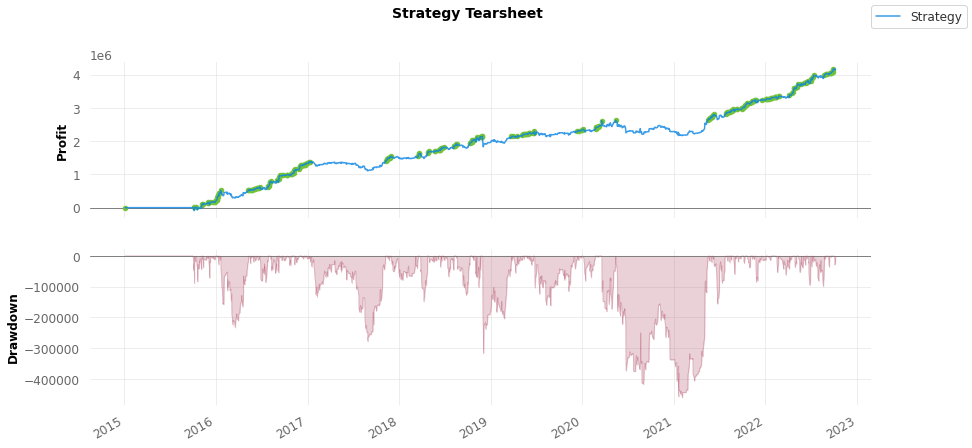

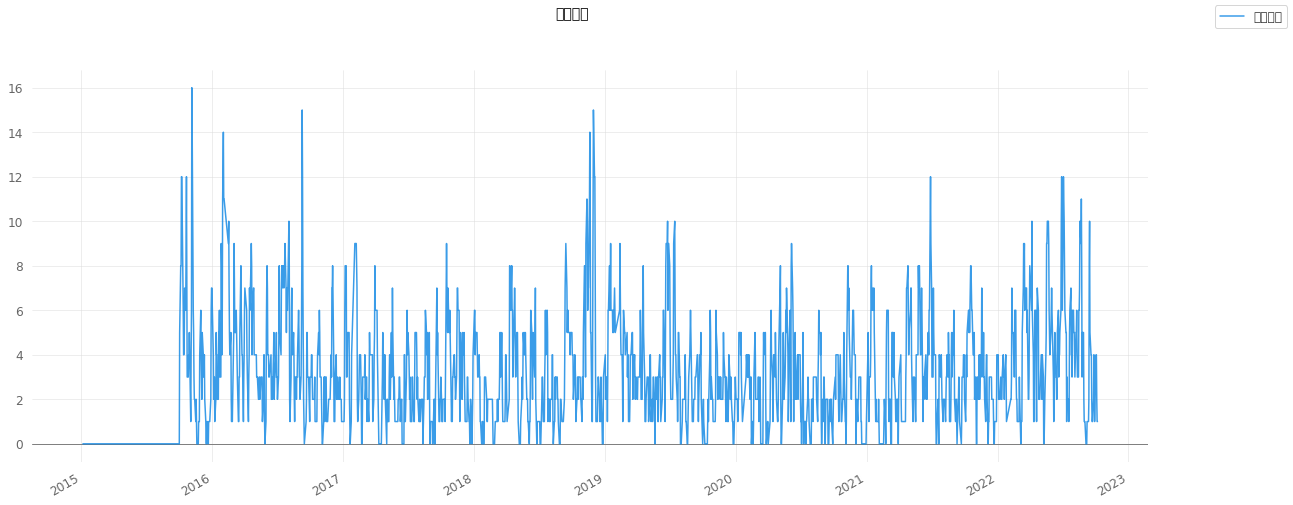

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [86]:
%%time
import importlib
%load_ext autoreload
%autoreload 2
importlib.reload(st)

backtest = st.Backtest(df[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']], trade_position=trade_position,  stockCash=-500000, ndays=5)
report = ~backtest.run(strategy_map)
# profit = backtest.run(strategy_map)
# report = backtest.getDetailInfo(strategy_map)
profit = backtest.profit